# Screening and Diagnosis of esophageal cancer from in-vivo microscopy images


This is a <b>multi-class image classification problem</b> submitted by Mauna Kea Technologies on the Ecole Normale Supérieure platform:<br>
https://challengedata.ens.fr/participants/challenges/11/


During a screening procedure, Cellvizio® images move fast and physicians are juggling with a lot of information at the same time, which makes it sometimes tricky to not miss any valuable clinical information.    

<b>The goal of this challenge is to build an image classifier to assist physicians in the screening and diagnosis of esophageal cancer.</b> Such a tool would have a massive impact on patient management and patient lives.     

The proposed classes to be recognized are:    
- Squamous Epithelium  
- Intestinal Metaplasia  
- Gastric Metaplasia  
- Dysplasia/Cancer  




In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import os
import matplotlib.image as mpimg
import cv2

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Load labels

We have 4 classes :
- 0 is “Squamous_Epithelium”  
- 1 is “Intestinal_metaplasia”  
- 2 is “Gastric_metaplasia”  
- 3 is “Dysplasia_and_Cancer”


In [2]:
train_labels = pd.read_csv('TrainingSet_20aimVO.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EA477F6CC0>]],
      dtype=object)

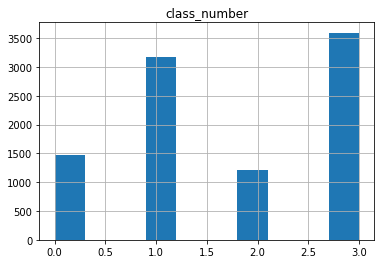

In [3]:
train_labels.hist()

In [64]:
from sklearn.utils import class_weight

# Estimate class weights to see how unbalanced is our dataset
class_weight = sklearn.utils.class_weight.compute_class_weight('balanced', 
                                                np.unique(train_labels.class_number), 
                                                train_labels.class_number)

In [91]:
class_weight

array([1.60755616, 0.7433113 , 1.95812604, 0.65706733])

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_labels.class_number)
encoded_Y = encoder.transform(train_labels.class_number)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

Using TensorFlow backend.


In [7]:
dummy_y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

### Load images

There is a total of 11161 images acquired from 61 patients.  

The training set provided contains 9446 images sized (519, 521, 3)

In [8]:
image_path = r"C:\Users\alexi\TrainingSetImagesDir"
train_labels['image_filename'] = train_labels['image_filename'].apply(lambda x: [os.path.join(image_path, x)])
train_labels['image_filename'] = train_labels['image_filename'].str.get(0)

In [10]:
# Load image dataset as a list of np.arrays
img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in train_labels['image_filename'][:]]

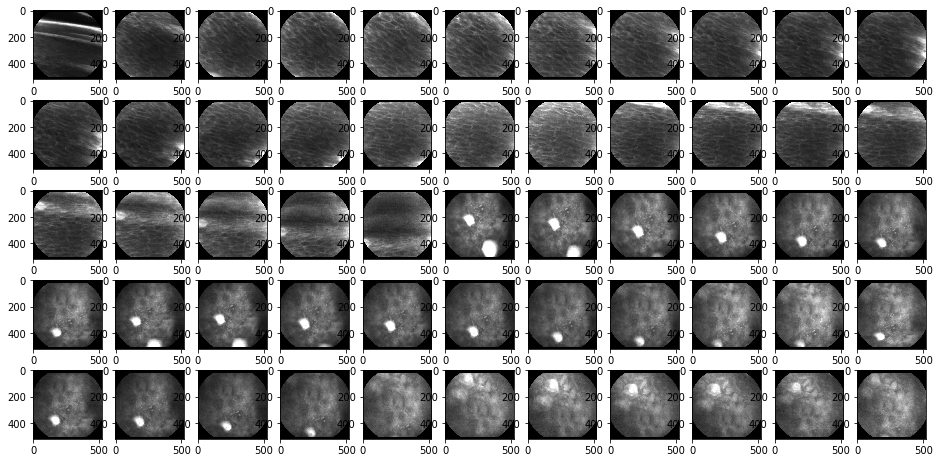

In [10]:
# Plot the first images from the dataset
w=10
h=10
fig=plt.figure(figsize=(16, 8))
columns = 11
rows = 5
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img[i])
plt.show()

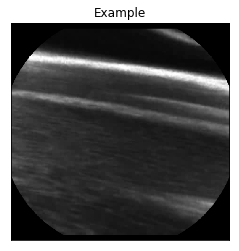

In [11]:
# Plot the first image
plt.imshow(img[0])
plt.title("Example")
plt.xticks([])
plt.yticks([])
plt.show()

## Preprocessing

Things we can do for preprocessing :
- Resize images
- Remove noise
- Segmentation
- Morphology(smoothing edges)

Then we have to split our dataset into : training, validation, test.

In [11]:
# resize into (227,227,3) for CNN 

res_img = []

for i in range(len(img)):
    res = cv2.resize(img[i], (227,227), interpolation=cv2.INTER_LINEAR)
    res_img.append(res)

In [12]:
# split and shuffle datasets into training, validation, test sets.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(res_img,
                                                    dummy_y, 
                                                    test_size=0.1, 
                                                    shuffle = True, 
                                                    random_state = 0)

x, X_cv, y, y_cv = train_test_split(X_train,
                                    y_train,
                                    test_size=0.1, 
                                    shuffle = True, 
                                    random_state = 0)

In [13]:
# convert list of arrays into array of arrays

X = np.array([i for i in x])
Y = np.array([i for i in y])

cv_x = np.array([i for i in X_cv])
cv_y = np.array([i for i in y_cv])

test_x = np.array([i for i in X_test])
test_y = np.array([i for i in y_test])

## Data check before learning

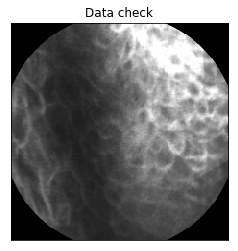

[1. 0. 0. 0.]


In [14]:
#print an image and it's label
plt.imshow(X[0])
plt.title("Data check")
plt.xticks([])
plt.yticks([])
plt.show()
print(Y[0])

In [96]:
# check the shapes of the different sets
print("Training set")
print("X: ", X.shape)
print("Y: ", Y.shape)
print("Validation set")
print("X: ", cv_x.shape)
print("Y: ", cv_y.shape)
print("Test set")
print("X: ", test_x.shape)
print("Y: ", test_y.shape)

Training set
X:  (7650, 227, 227, 3)
Y:  (7650, 4)
Validation set
X:  (851, 227, 227, 3)
Y:  (851, 4)
Test set
X:  (945, 227, 227, 3)
Y:  (945, 4)


# CNN  - Convolutional neural network

Each neuron focuses on it's own receiver field.

Convolutional neural networks are usefull when we have :
- <b>Partial local correlation</b>  
- <b>Relative spatial or temporal invariance</b>

<b>Conv2D layers:</b> for each convolution matrix and receiver field, a neuron calculate the convolution matrix for each receiver field. Then it performs a non linear transformation (Activation).<br>
This layer ensure the invariance by translation in images.

<b>Pooling layers:</b> deduce dimensionality by summarizing neighborhoods of neurons (with max or average)


In [43]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization

In [44]:
# create model
model = Sequential()

model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())

model.add(Flatten())

model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=84, activation='relu'))

model.add(Dense(units=10, activation = 'relu'))

model.add(Dense(4))
model.add(Activation('softmax'))

In [45]:
# model details
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_7 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 25, 25, 6)         5190      
_________________________________________________________________
average_pooling2d_7 (Average (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 16)        880       
_________________________________________________________________
average_pooling2d_8 (Average (None, 5, 5, 16)          0         
__________

In [46]:
# compile model using categorical_accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [51]:
hist = model.fit(x=X,y=Y, epochs=15, batch_size=128, validation_data=(cv_x, cv_y), verbose=1) 

Train on 7650 samples, validate on 851 samples
Epoch 1/15
7650/7650 [==============================] - 243s 32ms/step - loss: 1.2467 - categorical_accuracy: 0.4055 - val_loss: 1.2356 - val_categorical_accuracy: 0.4266
Epoch 2/15
7650/7650 [==============================] - 248s 32ms/step - loss: 1.1429 - categorical_accuracy: 0.4672 - val_loss: 1.0657 - val_categorical_accuracy: 0.5088
Epoch 3/15
7650/7650 [==============================] - 237s 31ms/step - loss: 1.0704 - categorical_accuracy: 0.5344 - val_loss: 1.0258 - val_categorical_accuracy: 0.5253
Epoch 4/15
7650/7650 [==============================] - 231s 30ms/step - loss: 0.9469 - categorical_accuracy: 0.5954 - val_loss: 0.9757 - val_categorical_accuracy: 0.5593
Epoch 5/15
7650/7650 [==============================] - 230s 30ms/step - loss: 0.8922 - categorical_accuracy: 0.6238 - val_loss: 0.9444 - val_categorical_accuracy: 0.5958
Epoch 6/15
7650/7650 [==============================] - 241s 31ms/step - loss: 0.8167 - categorica

## Evaluate the model

$ Non ~weighted ~Multiclass ~accuracy =  \frac{Number ~of ~images ~in ~the ~test ~set ~automatically ~assigned ~to ~the ~correct ~class}{Number ~of ~images ~in ~the ~test ~set} $ 

In [52]:
test_score = model.evaluate(test_x, test_y)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100)) 

945/945 [==============================] - 13s 14ms/step
Test loss 0.9936, accuracy 68.25%


Text(0, 0.5, 'acc')

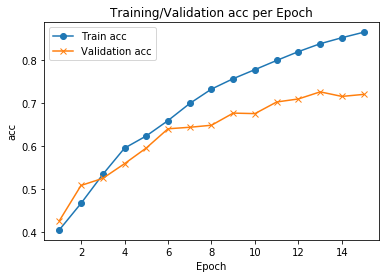

In [53]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot([None] + hist.history['categorical_accuracy'], 'o-')
ax.plot([None] + hist.history['val_categorical_accuracy'], 'x-')
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc') 

Text(0, 0.5, 'Loss')

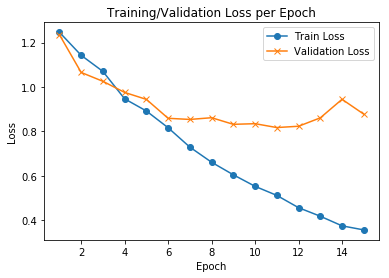

In [54]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot([None] + hist.history['loss'], 'o-')
ax.plot([None] + hist.history['val_loss'], 'x-')
ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss') 

In [55]:
model.predict_classes(test_x[20:24])

array([1, 3, 1, 3], dtype=int64)

In [56]:
test_y[20:24]

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

# Submission

The submission file should be a .cvs file <br>
with (N+1) lines (N = number of images in the test set, +1 = header) <br>
and 2 columns (1st column = im_XXX, 2nd column = class digit).

In [66]:
test_data_order = pd.read_csv('test_data_order.csv')
submission = pd.read_csv('test_data_order.csv')
image_test_path = r"C:\Users\alexi\TestSetImagesDir"

In [73]:
# Preprocessing cell

test_data_order['image_filename'] = test_data_order['image_filename'].apply(lambda x: [os.path.join(image_test_path, x)])
test_data_order['image_filename'] = test_data_order['image_filename'].str.get(0)

img_test = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in test_data_order['image_filename'][:]]

res_img_test = []

for i in range(len(img_test)):
    res_test = cv2.resize(img_test[i], (227,227), interpolation=cv2.INTER_LINEAR)
    res_img_test.append(res_test)

X_sub = np.array([i for i in res_img_test])

In [90]:
# This is the cell to run for new submission

submission['y_test_pred_csv_file'] = model.predict_classes(X_sub)
pd.DataFrame(submission).to_csv('submission_ENS_cnn.csv', index=False)